In [1]:
# GNN: Graph Neural Network
# 画像に対するCNNの一般化みたいなノリでグラフに畳み込み演算をしてみるみたいな話
# Coraという論文の引用グラフを利用．頂点が論文，辺が引用関係
# 頂点ごとにbag-of-wordsで特徴ベクトルを作って，引用関係に基づいて畳み込み
# 最終的に各頂点の分野を予測して頂点を分類するタスク

In [13]:
import os 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import networkx as nx

In [3]:
# prepare dataset
# - #nodes 2708
# - #classes 7
# - #edges 5429
# 頂点は1433次元の二値ベクトルを特徴ベクトルとして持つ

In [4]:
zip_file = keras.utils.get_file(
    fname="cora.tgz",
    origin="https://linqs-data.soe.ucsc.edu/public/lbc/cora.tgz",
    extract=True,
)
data_dir = os.path.join(os.path.dirname(zip_file), "cora")

172032/168052 [==============================] - 0s 2us/step


In [5]:
citations = pd.read_csv(
    os.path.join(data_dir, "cora.cites"),
    sep="\t",
    header=None,
    names=["target", "source"],
)
print("Citations shape:", citations.shape)

Citations shape: (5429, 2)


In [6]:
citations.sample(frac=1).head()

,target,source
662,2665,578306
699,2698,99025
852,3229,444191
2429,23774,1106406
1674,10174,10186


In [7]:
column_names = ["paper_id"] + [f"term_{idx}" for idx in range(1433)] + ["subject"]
papers = pd.read_csv(
    os.path.join(data_dir, "cora.content"), sep="\t", header=None, names=column_names,
)
print("Papers shape:", papers.shape)

Papers shape: (2708, 1435)


In [8]:
papers

,paper_id,term_0,term_1,term_2,term_3,term_4,term_5,term_6,term_7,term_8,term_9,term_10,term_11,term_12,term_13,term_14,term_15,term_16,term_17,term_18,term_19,term_20,term_21,term_22,term_23,term_24,term_25,term_26,term_27,term_28,term_29,term_30,term_31,term_32,term_33,term_34,term_35,term_36,term_37,term_38,...,term_1394,term_1395,term_1396,term_1397,term_1398,term_1399,term_1400,term_1401,term_1402,term_1403,term_1404,term_1405,term_1406,term_1407,term_1408,term_1409,term_1410,term_1411,term_1412,term_1413,term_1414,term_1415,term_1416,term_1417,term_1418,term_1419,term_1420,term_1421,term_1422,term_1423,term_1424,term_1425,term_1426,term_1427,term_1428,term_1429,term_1430,term_1431,term_1432,subject
0,31336,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,Neural_Networks
1,1061127,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,Rule_Learning
2,1106406,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,Reinforcement_Learning
3,13195,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Reinforcement_Learning
4,37879,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Probabilistic_Methods
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2703,1128975,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Genetic_Algorithms
2704,1128977,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Genetic_Algorithms
2705,1128978,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Genetic_Algorithms
2706,117328,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,Case_Based


In [9]:
class_values = sorted(papers["subject"].unique())
class_idx = {name: id for id, name in enumerate(class_values)}
paper_idx = {name: idx for idx, name in enumerate(sorted(papers["paper_id"].unique()))}

papers["paper_id"] = papers["paper_id"].apply(lambda name: paper_idx[name])
citations["source"] = citations["source"].apply(lambda name: paper_idx[name])
citations["target"] = citations["target"].apply(lambda name: paper_idx[name])
papers["subject"] = papers["subject"].apply(lambda value: class_idx[value])

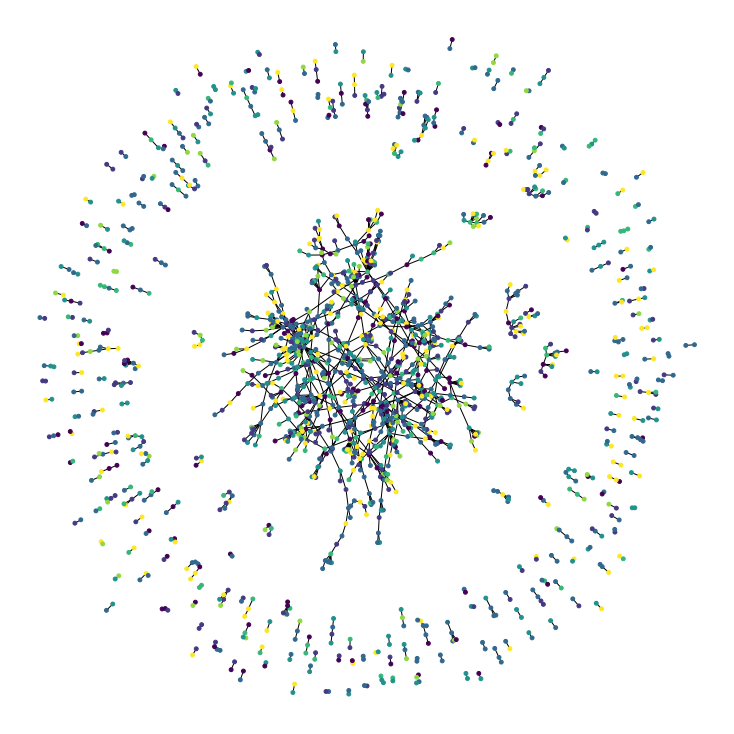

In [14]:
# visualise citation network
plt.figure(figsize=(10, 10))
colors = papers["subject"].tolist()
cora_graph = nx.from_pandas_edgelist(citations.sample(n=1500))
subjects = list(papers[papers["paper_id"].isin(list(cora_graph.nodes))]["subject"])
nx.draw_spring(cora_graph, node_size=15, node_color=subjects)

In [15]:
# split dataset into train_data and test_data
train_data, test_data = [], []

for _, group_data in papers.groupby("subject"):
    # Select around 50% of the dataset for training.
    random_selection = np.random.rand(len(group_data.index)) <= 0.5
    train_data.append(group_data[random_selection])
    test_data.append(group_data[~random_selection])

train_data = pd.concat(train_data).sample(frac=1)
test_data = pd.concat(test_data).sample(frac=1)

print("Train data shape:", train_data.shape)
print("Test data shape:", test_data.shape)

Train data shape: (1352, 1435)
Test data shape: (1356, 1435)


In [17]:
hidden_units = [32, 32]
learning_rate = 0.01
dropout_rate = 0.5
num_epochs = 300
batch_size = 256

In [18]:
def run_experiment(model, x_train, y_train):
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")]
    )
    
    early_stopping = keras.callbacks.EarlyStopping(
        monitor="val_acc", patience=50, restore_best_weights=True
    )

    history = model.fit(
        x=x_train,
        y=y_train,
        epochs=num_epochs,
        batch_size=batch_size,
        validation_split=0.15,
        callbacks=[early_stopping]
    )

    return history

In [19]:
def display_learning_curves(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax1.plot(history.history["loss"])
    ax1.plot(history.history["val_loss"])
    ax1.legend(["train", "test"], loc="upper right")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")

    ax2.plot(history.history["acc"])
    ax2.plot(history.history["val_acc"])
    ax2.legend(["train", "test"], loc="upper right")
    ax2.set_xlabel("Epochs")
    ax2.set_ylabel("Accuracy")
    plt.show()

In [20]:
# Feedforward Network
def create_ffn(hidden_units, dropout_rate, name=None):
    fnn_layers = []

    for units in hidden_units:
        fnn_layers.append(layers.BatchNormalization())
        fnn_layers.append(layers.Dropout(dropout_rate))
        fnn_layers.append(layers.Dense(units, activation=tf.nn.gelu))

    return keras.Sequential(fnn_layers, name=name)

In [21]:
feature_names = set(papers.columns) - {"paper_id", "subject"}
num_features = len(feature_names)
num_classes = len(class_idx)

# Create train and test features as a numpy array.
x_train = train_data[feature_names].to_numpy()
x_test = test_data[feature_names].to_numpy()
# Create train and test targets as a numpy array.
y_train = train_data["subject"]
y_test = test_data["subject"]

In [22]:
def create_baseline_model(hidden_units, num_classes, dropout_rate=0.2):
    inputs = layers.Input(shape=(num_features,), name="input_features")
    x = create_ffn(hidden_units, dropout_rate, name=f"ffn_block1")(inputs)
    for block_idx in range(4):
        # Create an FFN block.
        x1 = create_ffn(hidden_units, dropout_rate, name=f"ffn_block{block_idx + 2}")(x)
        # Add skip connection.
        x = layers.Add(name=f"skip_connection{block_idx + 2}")([x, x1])
    # Compute logits.
    logits = layers.Dense(num_classes, name="logits")(x)
    # Create the model.
    return keras.Model(inputs=inputs, outputs=logits, name="baseline")


baseline_model = create_baseline_model(hidden_units, num_classes, dropout_rate)
baseline_model.summary()

Model: "baseline"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_features (InputLayer)     [(None, 1433)]       0                                            
__________________________________________________________________________________________________
ffn_block1 (Sequential)         (None, 32)           52804       input_features[0][0]             
__________________________________________________________________________________________________
ffn_block2 (Sequential)         (None, 32)           2368        ffn_block1[0][0]                 
__________________________________________________________________________________________________
skip_connection2 (Add)          (None, 32)           0           ffn_block1[0][0]                 
                                                                 ffn_block2[0][0]          

In [23]:
history = run_experiment(baseline_model, x_train, y_train)

Epoch 1/300
5/5 [==============================] - 4s 128ms/step - loss: 3.2856 - acc: 0.1697 - val_loss: 1.9685 - val_acc: 0.1330
Epoch 2/300
5/5 [==============================] - 0s 24ms/step - loss: 2.6137 - acc: 0.2106 - val_loss: 1.9315 - val_acc: 0.1379
Epoch 3/300
5/5 [==============================] - 0s 26ms/step - loss: 2.2378 - acc: 0.2576 - val_loss: 1.9472 - val_acc: 0.1576
Epoch 4/300
5/5 [==============================] - 0s 24ms/step - loss: 2.1417 - acc: 0.2228 - val_loss: 1.9520 - val_acc: 0.1675
Epoch 5/300
5/5 [==============================] - 0s 24ms/step - loss: 1.9581 - acc: 0.2620 - val_loss: 1.9290 - val_acc: 0.2414
Epoch 6/300
5/5 [==============================] - 0s 23ms/step - loss: 1.8896 - acc: 0.2707 - val_loss: 1.9005 - val_acc: 0.2512
Epoch 7/300
5/5 [==============================] - 0s 25ms/step - loss: 1.8223 - acc: 0.3011 - val_loss: 1.8779 - val_acc: 0.3103
Epoch 8/300
5/5 [==============================] - 0s 23ms/step - loss: 1.7262 - acc: 0.3

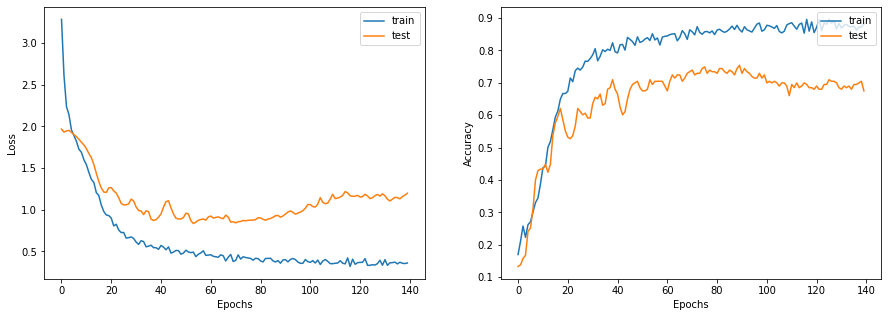

In [24]:
display_learning_curves(history)

In [25]:
_, test_accuracy = baseline_model.evaluate(x=x_test, y=y_test, verbose=0)
print(f"Test accuracy: {round(test_accuracy * 100, 2)}%")

Test accuracy: 73.01%


In [26]:
def generate_random_instances(num_instances):
    token_probability = x_train.mean(axis=0)
    instances = []
    for _ in range(num_instances):
        probabilities = np.random.uniform(size=len(token_probability))
        instance = (probabilities <= token_probability).astype(int)
        instances.append(instance)

    return np.array(instances)


def display_class_probabilities(probabilities):
    for instance_idx, probs in enumerate(probabilities):
        print(f"Instance {instance_idx + 1}:")
        for class_idx, prob in enumerate(probs):
            print(f"- {class_values[class_idx]}: {round(prob * 100, 2)}%")

In [27]:
new_instances = generate_random_instances(num_classes)
logits = baseline_model.predict(new_instances)
probabilities = keras.activations.softmax(tf.convert_to_tensor(logits)).numpy()
display_class_probabilities(probabilities)

Instance 1:
- Case_Based: 9.63%
- Genetic_Algorithms: 7.6%
- Neural_Networks: 9.18%
- Probabilistic_Methods: 31.13%
- Reinforcement_Learning: 0.63%
- Rule_Learning: 17.67%
- Theory: 24.16%
Instance 2:
- Case_Based: 0.1%
- Genetic_Algorithms: 0.21%
- Neural_Networks: 53.27%
- Probabilistic_Methods: 1.32%
- Reinforcement_Learning: 0.09%
- Rule_Learning: 0.02%
- Theory: 44.98%
Instance 3:
- Case_Based: 0.82%
- Genetic_Algorithms: 15.25%
- Neural_Networks: 15.91%
- Probabilistic_Methods: 43.7%
- Reinforcement_Learning: 3.1%
- Rule_Learning: 1.39%
- Theory: 19.82%
Instance 4:
- Case_Based: 0.32%
- Genetic_Algorithms: 0.32%
- Neural_Networks: 2.48%
- Probabilistic_Methods: 92.52%
- Reinforcement_Learning: 0.2%
- Rule_Learning: 0.12%
- Theory: 4.05%
Instance 5:
- Case_Based: 9.23%
- Genetic_Algorithms: 1.91%
- Neural_Networks: 6.26%
- Probabilistic_Methods: 2.19%
- Reinforcement_Learning: 0.56%
- Rule_Learning: 61.41%
- Theory: 18.44%
Instance 6:
- Case_Based: 0.05%
- Genetic_Algorithms: 0.32

In [28]:
# GNN

In [30]:
# Create an edges array (sparse adjacency matrix) of shape [2, num_edges].
edges = citations[["source", "target"]].to_numpy().T
# Create an edge weights array of ones.
edge_weights = tf.ones(shape=edges.shape[1])
# Create a node features array of shape [num_nodes, num_features].
node_features = tf.cast(
    papers.sort_values("paper_id")[feature_names].to_numpy(), dtype=tf.dtypes.float32
)
# Create graph info tuple with node_features, edges, and edge_weights.
graph_info = (node_features, edges, edge_weights)

print("Edges shape:", edges.shape)
print("Nodes shape:", node_features.shape)

Edges shape: (2, 5429)
Nodes shape: (2708, 1433)


In [31]:
class GraphConvLayer(layers.Layer):
    def __init__(
        self,
        hidden_units,
        dropout_rate=0.2,
        aggregation_type="mean",
        combination_type="concat",
        normalize=False,
        *args,
        **kwargs,
    ):
        super(GraphConvLayer, self).__init__(*args, **kwargs)

        self.aggregation_type = aggregation_type
        self.combination_type = combination_type
        self.normalize = normalize

        self.ffn_prepare = create_ffn(hidden_units, dropout_rate)
        if self.combination_type == "gated":
            self.update_fn = layers.GRU(
                units=hidden_units,
                activation="tanh",
                recurrent_activation="sigmoid",
                dropout=dropout_rate,
                return_state=True,
                recurrent_dropout=dropout_rate,
            )
        else:
            self.update_fn = create_ffn(hidden_units, dropout_rate)

    def prepare(self, node_repesentations, weights=None):
        # node_repesentations shape is [num_edges, embedding_dim].
        messages = self.ffn_prepare(node_repesentations)
        if weights is not None:
            messages = messages * tf.expand_dims(weights, -1)
        return messages

    def aggregate(self, node_indices, neighbour_messages):
        # node_indices shape is [num_edges].
        # neighbour_messages shape: [num_edges, representation_dim].
        num_nodes = tf.math.reduce_max(node_indices) + 1
        if self.aggregation_type == "sum":
            aggregated_message = tf.math.unsorted_segment_sum(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        elif self.aggregation_type == "mean":
            aggregated_message = tf.math.unsorted_segment_mean(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        elif self.aggregation_type == "max":
            aggregated_message = tf.math.unsorted_segment_max(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        else:
            raise ValueError(f"Invalid aggregation type: {self.aggregation_type}.")

        return aggregated_message

    def update(self, node_repesentations, aggregated_messages):
        # node_repesentations shape is [num_nodes, representation_dim].
        # aggregated_messages shape is [num_nodes, representation_dim].
        if self.combination_type == "gru":
            # Create a sequence of two elements for the GRU layer.
            h = tf.stack([node_repesentations, aggregated_messages], axis=1)
        elif self.combination_type == "concat":
            # Concatenate the node_repesentations and aggregated_messages.
            h = tf.concat([node_repesentations, aggregated_messages], axis=1)
        elif self.combination_type == "add":
            # Add node_repesentations and aggregated_messages.
            h = node_repesentations + aggregated_messages
        else:
            raise ValueError(f"Invalid combination type: {self.combination_type}.")

        # Apply the processing function.
        node_embeddings = self.update_fn(h)
        if self.combination_type == "gru":
            node_embeddings = tf.unstack(node_embeddings, axis=1)[-1]

        if self.normalize:
            node_embeddings = tf.nn.l2_normalize(node_embeddings, axis=-1)
        return node_embeddings

    def call(self, inputs):
        """Process the inputs to produce the node_embeddings.

        inputs: a tuple of three elements: node_repesentations, edges, edge_weights.
        Returns: node_embeddings of shape [num_nodes, representation_dim].
        """

        node_repesentations, edges, edge_weights = inputs
        # Get node_indices (source) and neighbour_indices (target) from edges.
        node_indices, neighbour_indices = edges[0], edges[1]
        # neighbour_repesentations shape is [num_edges, representation_dim].
        neighbour_repesentations = tf.gather(node_repesentations, neighbour_indices)

        # Prepare the messages of the neighbours.
        neighbour_messages = self.prepare(neighbour_repesentations, edge_weights)
        # Aggregate the neighbour messages.
        aggregated_messages = self.aggregate(node_indices, neighbour_messages)
        # Update the node embedding with the neighbour messages.
        return self.update(node_repesentations, aggregated_messages)

In [32]:
class GNNNodeClassifier(tf.keras.Model):
    def __init__(
        self,
        graph_info,
        num_classes,
        hidden_units,
        aggregation_type="sum",
        combination_type="concat",
        dropout_rate=0.2,
        normalize=True,
        *args,
        **kwargs,
    ):
        super(GNNNodeClassifier, self).__init__(*args, **kwargs)

        # Unpack graph_info to three elements: node_features, edges, and edge_weight.
        node_features, edges, edge_weights = graph_info
        self.node_features = node_features
        self.edges = edges
        self.edge_weights = edge_weights
        # Set edge_weights to ones if not provided.
        if self.edge_weights is None:
            self.edge_weights = tf.ones(shape=edges.shape[1])
        # Scale edge_weights to sum to 1.
        self.edge_weights = self.edge_weights / tf.math.reduce_sum(self.edge_weights)

        # Create a process layer.
        self.preprocess = create_ffn(hidden_units, dropout_rate, name="preprocess")
        # Create the first GraphConv layer.
        self.conv1 = GraphConvLayer(
            hidden_units,
            dropout_rate,
            aggregation_type,
            combination_type,
            normalize,
            name="graph_conv1",
        )
        # Create the second GraphConv layer.
        self.conv2 = GraphConvLayer(
            hidden_units,
            dropout_rate,
            aggregation_type,
            combination_type,
            normalize,
            name="graph_conv2",
        )
        # Create a postprocess layer.
        self.postprocess = create_ffn(hidden_units, dropout_rate, name="postprocess")
        # Create a compute logits layer.
        self.compute_logits = layers.Dense(units=num_classes, name="logits")

    def call(self, input_node_indices):
        # Preprocess the node_features to produce node representations.
        x = self.preprocess(self.node_features)
        # Apply the first graph conv layer.
        x1 = self.conv1((x, self.edges, self.edge_weights))
        # Skip connection.
        x = x1 + x
        # Apply the second graph conv layer.
        x2 = self.conv2((x, self.edges, self.edge_weights))
        # Skip connection.
        x = x2 + x
        # Postprocess node embedding.
        x = self.postprocess(x)
        # Fetch node embeddings for the input node_indices.
        node_embeddings = tf.squeeze(tf.gather(x, input_node_indices))
        # Compute logits
        return self.compute_logits(node_embeddings)

In [33]:
gnn_model = GNNNodeClassifier(
    graph_info=graph_info,
    num_classes=num_classes,
    hidden_units=hidden_units,
    dropout_rate=dropout_rate,
    name="gnn_model",
)

print("GNN output shape:", gnn_model([1, 10, 100]))

gnn_model.summary()

GNN output shape: tf.Tensor(
[[ 0.18764889  0.03787652  0.06460396 -0.04018654  0.11784144  0.10133038
   0.02737869]
 [-0.06358135  0.06085556 -0.02961819 -0.03311957  0.13858816 -0.01272357
  -0.03934512]
 [ 0.03464599  0.17174393  0.10629413 -0.02428859  0.06109162  0.00161106
  -0.14660424]], shape=(3, 7), dtype=float32)
Model: "gnn_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
preprocess (Sequential)      (2708, 32)                52804     
_________________________________________________________________
graph_conv1 (GraphConvLayer) multiple                  5888      
_________________________________________________________________
graph_conv2 (GraphConvLayer) multiple                  5888      
_________________________________________________________________
postprocess (Sequential)     (2708, 32)                2368      
____________________________________________________________

In [34]:
x_train = train_data.paper_id.to_numpy()
history = run_experiment(gnn_model, x_train, y_train)

Epoch 1/300
Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
5/5 [==============================] - 5s 300ms/step - loss: 2.2177 - acc: 0.1767 - val_loss: 1.9103 - val_acc: 0.2956
Epoch 2/300
5/5 [==============================] - 1s 173ms/step - loss: 1.9936 - acc: 0.2446 - val_loss: 1.8843 - val_acc: 0.3054
Epoch 3/300
5/5 [==============================] - 1s 172ms/step - loss: 1.9322 - acc: 0.2541 - val_loss: 1.8757 - val_acc: 0.3054
Epoch 4/300
5/5 [==============================] - 1s 175ms/step - loss: 1.8791 - acc: 0.2837 - val_loss: 1.8736 - val_acc: 0.3054
Epoch 5/300
5/5 [==============================] - 1s 178ms/step - loss: 1.8758 - acc: 0.2742 - val_loss: 1.8671 - val_acc: 0.3054
Epoch 6/300
5/5 [==============================] - 1s 177ms/step - loss: 1.8734 - acc: 0.2855 - val_loss: 1.8563 - val_acc: 0.3054
Epoch 7/300
5/5 [==============================] - 1s 179ms/step - loss: 1.8

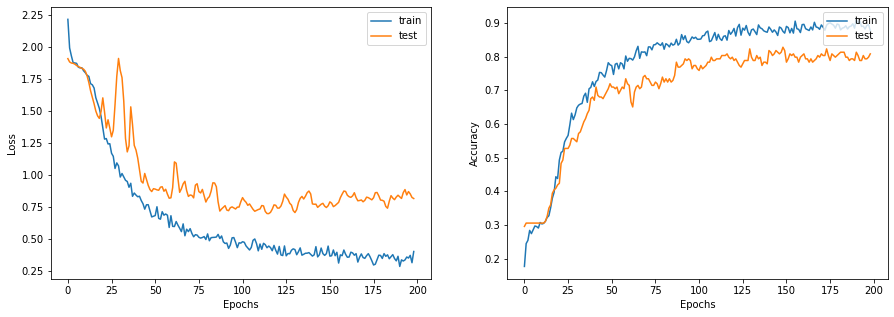

In [35]:
display_learning_curves(history)

In [36]:
x_test = test_data.paper_id.to_numpy()
_, test_accuracy = gnn_model.evaluate(x=x_test, y=y_test, verbose=0)
print(f"Test accuracy: {round(test_accuracy * 100, 2)}%")

Test accuracy: 80.9%


In [37]:
# First we add the N new_instances as nodes to the graph
# by appending the new_instance to node_features.
num_nodes = node_features.shape[0]
new_node_features = np.concatenate([node_features, new_instances])
# Second we add the M edges (citations) from each new node to a set
# of existing nodes in a particular subject
new_node_indices = [i + num_nodes for i in range(num_classes)]
new_citations = []
for subject_idx, group in papers.groupby("subject"):
    subject_papers = list(group.paper_id)
    # Select random x papers specific subject.
    selected_paper_indices1 = np.random.choice(subject_papers, 5)
    # Select random y papers from any subject (where y < x).
    selected_paper_indices2 = np.random.choice(list(papers.paper_id), 2)
    # Merge the selected paper indices.
    selected_paper_indices = np.concatenate(
        [selected_paper_indices1, selected_paper_indices2], axis=0
    )
    # Create edges between a citing paper idx and the selected cited papers.
    citing_paper_indx = new_node_indices[subject_idx]
    for cited_paper_idx in selected_paper_indices:
        new_citations.append([citing_paper_indx, cited_paper_idx])

new_citations = np.array(new_citations).T
new_edges = np.concatenate([edges, new_citations], axis=1)

In [38]:
print("Original node_features shape:", gnn_model.node_features.shape)
print("Original edges shape:", gnn_model.edges.shape)
gnn_model.node_features = new_node_features
gnn_model.edges = new_edges
gnn_model.edge_weights = tf.ones(shape=new_edges.shape[1])
print("New node_features shape:", gnn_model.node_features.shape)
print("New edges shape:", gnn_model.edges.shape)

logits = gnn_model.predict(tf.convert_to_tensor(new_node_indices))
probabilities = keras.activations.softmax(tf.convert_to_tensor(logits)).numpy()
display_class_probabilities(probabilities)

Original node_features shape: (2708, 1433)
Original edges shape: (2, 5429)
New node_features shape: (2715, 1433)
New edges shape: (2, 5478)
Instance 1:
- Case_Based: 3.68%
- Genetic_Algorithms: 11.31%
- Neural_Networks: 2.6%
- Probabilistic_Methods: 0.91%
- Reinforcement_Learning: 70.27%
- Rule_Learning: 7.34%
- Theory: 3.89%
Instance 2:
- Case_Based: 0.04%
- Genetic_Algorithms: 0.04%
- Neural_Networks: 0.48%
- Probabilistic_Methods: 0.09%
- Reinforcement_Learning: 0.03%
- Rule_Learning: 0.05%
- Theory: 99.28%
Instance 3:
- Case_Based: 0.12%
- Genetic_Algorithms: 1.25%
- Neural_Networks: 84.29%
- Probabilistic_Methods: 12.12%
- Reinforcement_Learning: 0.62%
- Rule_Learning: 0.05%
- Theory: 1.54%
Instance 4:
- Case_Based: 0.01%
- Genetic_Algorithms: 0.02%
- Neural_Networks: 0.88%
- Probabilistic_Methods: 98.58%
- Reinforcement_Learning: 0.02%
- Rule_Learning: 0.0%
- Theory: 0.49%
Instance 5:
- Case_Based: 7.74%
- Genetic_Algorithms: 6.36%
- Neural_Networks: 2.58%
- Probabilistic_Methods

In [ ]:
# bag-of-wordsで73%
# 引用関係を考慮して80%
# ある論文がどの分野の論文なのかを決めるに当たり，
# 中身の単語のほうが，引用関係より重要で，それだけを用いてもそれなりに当たる．
# 一方で，引用関係を追加するとちょっとだけ当たる精度がマシになる．